# Solution 3

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

# 1. Modeling the Volatility Smile

## Swaption Vol Data

The file `data/swaption_vol_data_2024-02-20.xlsx` has market data on the implied volatility skews for swaptions. Note that it has several columns:
* `expry`: expiration of the swaption
* `tenor`: tenor of the underlying swap
* `model`: the model by which the volatility is quoted. (All are Black.)
* `-200`, `-100`, etc.: The strike listed as difference from ATM strike (bps). Note that ATM is considered to be the **forward swapa rate** which you can calculate.

Your data: ywill use a single row of this data for the `1x4` swaption.
* date: `2024-02-20`
* expiration: 1yr
* tenor: 4yrs

## Rate Data

The file `data/cap_quotes_2024-02-20.xlsx` gives 
* SOFR swap rates, 
* their associated discount factors
* their associated forward interest rates.

You will not need the cap data (flat or forward vols) for this problem.
* This cap data would be helpful in calibrating a binomial tree, but this problem focuses on Black's formula and SABR.

## The Swaption

Consider the following swaption with the following features:
* underlying is a fixed-for-floating (SOFR) swap
* the underlying swap has **quarterly** payment frequency
* this is a **payer** swaption, which gives the holder the option to **pay** the fixed swap rate and receive SOFR.

## 1.1
Calculate the (relevant) forward swap rate. That is, the one-year forward 4-year swap rate.

## 1.2
Price the swaptions at the quoted implied volatilites and corresponding strikes, all using the just-calculated forward swap rate as the underlying.

## 1.3
To consider how the expiration and tenor matter, calculate the prices of a few other swaptions for comparison. 
* No need to get other implied vol quotes--just use the ATM implied vol you have for the 1x2 above. (Here we are just interested in how Black's formula changes with changes in tenor and expiration.
* No need to calculate for all the strikes--just do the ATM strike.

Alternate swaptions
* The 3mo x 4yr swaption
* The 2yr x 4yr swaption
* the 1yr x 2yr swaption

Report these values and compare them to the price of the `1y x 4y` swaption.

***

# **<span style="color:red">Solutions</span>**

In [1]:
import numpy as np
import pandas as pd

from datetime import date
from datetime import datetime

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *
from treasury_cmds import compound_rate
from volskew import *

In [2]:
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

# **<span style="color:red">Solution 1</span>**

In [3]:
DATE = '2024-02-20'
freqcurve = 4

SWAP_TYPE = 'SOFR'
QUOTE_STYLE = 'black'
RELATIVE_STRIKE = 0

expry = 1
tenor = 4

freqswap = 4
isPayer=True
N = 100

In [4]:
curves = pd.read_excel(f'../data/cap_curves_{DATE}.xlsx', sheet_name=f'rate curves {DATE}').set_index('tenor')

Topt = expry
Tswap = Topt+tenor

fwdrate = curves['forwards'][Topt]

fwdswap = calc_fwdswaprate(curves['discounts'], Topt, Tswap, freqswap=freqswap)

## **<span style="color:red">1.1</span>**

In [5]:
display(f'The forward swap rate is {fwdswap:.2%}')

'The forward swap rate is 3.67%'

## **<span style="color:red">1.2</span>**

### Import and Process Quoted Vols

In [6]:
voldata = pd.read_excel('../data/swaption_vol_data.xlsx')
volquote = voldata.query(f'model=="{QUOTE_STYLE}"').query(f'reference=="{SWAP_TYPE}"').query(f'date=="{DATE}"')
idx = (volquote['expiration']==expry) & (volquote['tenor']==tenor)
volquote = volquote.loc[idx]
volquote.index = ['implied vol']

volquote

,reference,instrument,model,date,expiration,tenor,-200,-100,-50,-25,0,25,50,100,200
implied vol,SOFR,swaption,black,2024-02-20,1,4,54.54,40.37,35.94,34.23,32.83,31.71,30.86,29.83,29.54


In [7]:
strikerange = np.array(volquote.columns[-9:].tolist())
vols = volquote[strikerange]
vols /= 100
strikes = fwdswap + strikerange/100/100
idstrike = np.where(strikerange==RELATIVE_STRIKE)[0][0]

idstrikeATM = np.where(strikerange==0)[0][0]

if QUOTE_STYLE == 'normal':
    vols /= 100 * fwdrate

capvol = curves.loc[Topt,'fwd vols']

strikeATM = strikes[idstrikeATM]
volATM = vols.iloc[0,idstrikeATM]

### Use Black's Formula

In [8]:
period_fwd = curves.index.get_loc(Topt)
period_swap = curves.index.get_loc(Tswap)+1
step = round(freqcurve/freqswap)

discount = curves['discounts'].iloc[period_fwd+step : period_swap : step].sum()/freqswap
blacks_quotes = vols.copy()
blacks_quotes.loc['price'] = N * blacks_formula(Topt,vols,strikes,fwdswap,discount,isCall=isPayer)[0]
blacks_quotes.loc['strike'] = strikes
blacks_quotes = blacks_quotes.loc[['strike','implied vol','price']]

blacks_quotes.style.format('{:.4f}')

,-200,-100,-50,-25,0,25,50,100,200
strike,0.0167,0.0267,0.0317,0.0342,0.0367,0.0392,0.0417,0.0467,0.0567
implied vol,0.5454,0.4037,0.3594,0.3423,0.3283,0.3171,0.3086,0.2983,0.2954
price,7.2031,4.0653,2.7398,2.1749,1.6874,1.2812,0.9556,0.5133,0.1473


## **<span style="color:red">1.3</span>**

In [9]:
expiries = [.25,1,2,1]
tenors = [4,4,4,2]
fwdswaps = np.full(len(expiries),np.nan)

blacks_quotes_alt = pd.DataFrame(dtype=float,columns=['expiry','tenor','price'])
    
for i in range(len(fwdswaps)):
    fwdswaps[i] = calc_fwdswaprate(curves['discounts'], expiries[i], expiries[i]+tenors[i], freqswap=freqswap)
    
    period0 = curves.index.get_loc(expiries[i])
    period1 = curves.index.get_loc(expiries[i]+tenors[i])+1
    step_i = round(freqcurve/freqswap)

    discount_i = curves['discounts'].iloc[period0+step_i : period1 : step_i].sum()/freqswap

    blacks_quotes_alt.loc[i,['expiry','tenor']] = [expiries[i],tenors[i]]
    blacks_quotes_alt.loc[i,'price'] = N * blacks_formula(expiries[i],volATM,strikeATM,fwdswap,discount_i,isCall=isPayer)

    
def highlight_row(row):
    if row.name == 1:
        return ['background-color: yellow'] * len(row)
    else:
        return [''] * len(row)
    
blacks_quotes_alt.style.apply(highlight_row,axis=1).format({'expiry':'{:.2f}', 'tenor':'{:.2f}', 'price':'{:.4f}'})

,expiry,tenor,price
0,0.25,4.00,0.8705
1,1.00,4.00,1.6874
2,2.00,4.00,2.2914
3,1.00,2.00,0.8740


***

# 2. Pricing w/ BDT

Use the data in `cap_curves_2024-02-20.xlsx`.

## 2.1

Calibrate the BDT Tree
* theta to fit the term structure discounts.
* sigma to fit the fwd vols from the cap data.

Report the rate tree through $T=5$. Report trees for rates compounded
* continuously
* annually

## 2.2

Use a tree to price a vanilla fixed-rate, 5-year bond with coupon rate equal to the forward swap rate calculated in problem `1.1.`

## 2.3

We will calculate the binomial tree for the 5-year swap, but here we do so by valuing the swap as...

$$\text{payer swap} = \text{floating rate note} - \text{fixed-rate bond}$$

Recall for the Floating-Rate Note:
* It has par value of 100 at each reset date.
* Every node is a reset date given the assumptions of the swap timing.

Report the tree for the 5-year swap.

## 2.4



Report the binomial tree for the one-year European swaption on a 4-year swap.
* At expiration, the swap tree from 2.3 will have 4 years left, as desired for pricing the 1y-4y swaption.

## 2.5

Compare the pricing of the 1y4y swaption from Black's formula in Section 1 vs the binomial tree.

## 2.6

Reprice the swaption using the BDT tree, but this time assuming it is American exercise.

***

# **<span style="color:red">Solution 2</span>**

## **<span style="color:red">2.1</span>**

#### Interpolate curves to Tree Grid

In [10]:
FREQTREE = 4
dt = 1/FREQTREE

newgrid = np.arange(dt,curves.index[-1]+dt,dt).round(6)
curvesint = pd.DataFrame(dtype=float, columns=curves.columns, index=newgrid)
cols_interp = ['swap rates','flat vols','fwd vols']

# interpolate
curvesint = pd.concat([curvesint,curves],axis=0)
curvesint = curvesint.interpolate(method='cubicspline',fill_value='extrapolate',limit_direction='both')
curvesint = curvesint.loc[newgrid,:]
curvesint = curvesint[~curvesint.index.duplicated()].sort_index()

# compute derived curves
curvesint['discounts'] = ratecurve_to_discountcurve(curvesint['swap rates'],n_compound=FREQTREE)
curvesint['forwards'] = ratecurve_to_forwardcurve(curvesint['swap rates'],n_compound=FREQTREE)

# forward vol is derived but can't extract curve--interpolate and adjust front to first flat vol
id0 = curves['flat vols'].dropna().index[0]
curvesint.loc[:id0,['flat vols','fwd vols']] = curves.loc[id0,'flat vols']

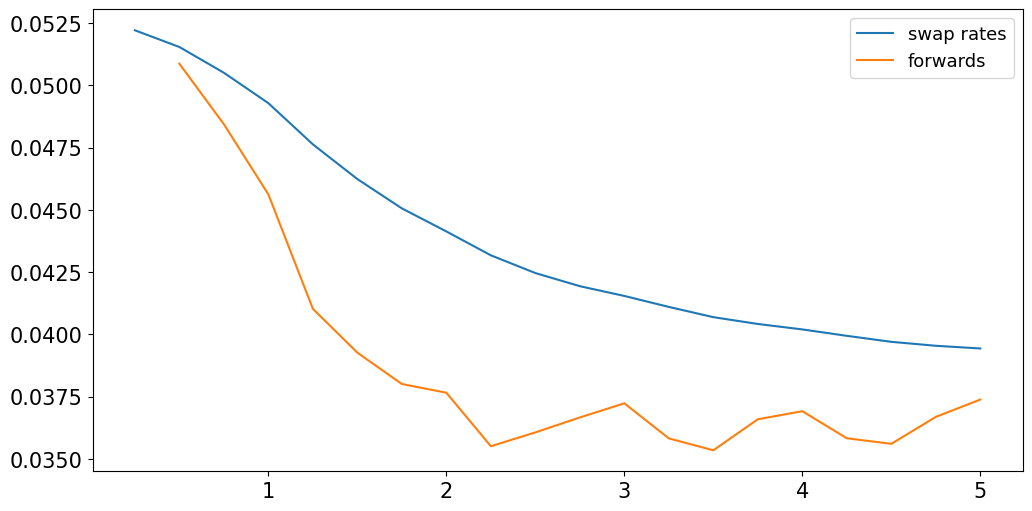

In [11]:
curvesint[['swap rates','forwards']].loc[:Tswap].plot();

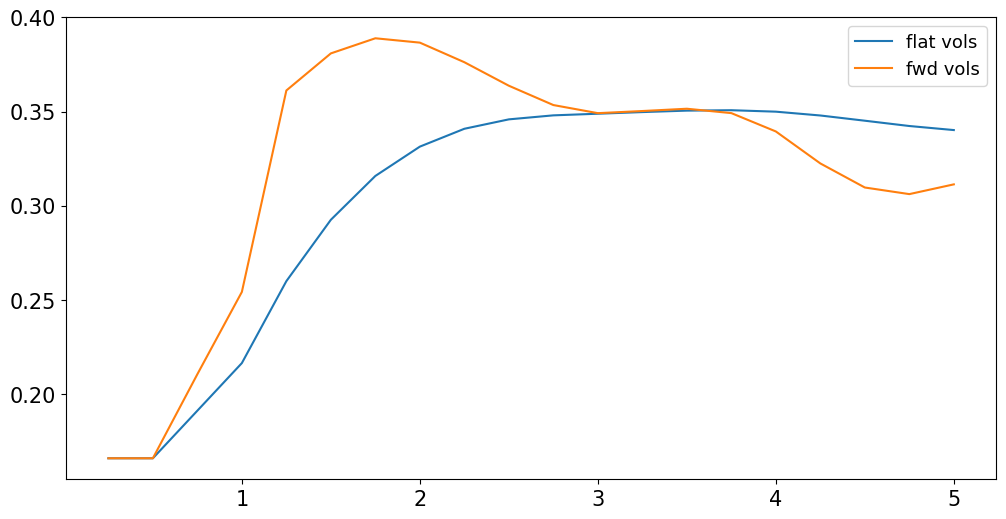

In [12]:
curvesint[['flat vols','fwd vols']].loc[:Tswap].plot();

#### Market Rates

In [13]:
quotes = curves['discounts']
swaprate = calc_swaprate(quotes, Tswap, freqswap=freqswap)
fwdswap = calc_fwdswaprate(quotes, Topt, Tswap, freqswap=freqswap)
fwdrate = curves['forwards'][Topt]

#### Build BDT Rate Tree

In [14]:
sigmas = curvesint['fwd vols']
sigmas.iloc[0] = sigmas.iloc[1]
sigmas.index = sigmas.index.to_numpy().round(6)

theta, ratetree = estimate_theta(sigmas.loc[:Tswap],100*curvesint.loc[:Tswap,'discounts'])

## **<span style="color:red">2.2 and 2.3</span>**

In [15]:
freqcpn = freqswap
strike = strikes[idstrike]
cpn = strike

wrapper_bond = lambda r: payoff_bond(r, 1/FREQTREE, facevalue=N * (1+cpn/freqcpn))
cftree = construct_bond_cftree(Tswap, FREQTREE, cpn, cpn_freq=freqcpn, face=N)
bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree, cftree=cftree)

if isPayer:
    swaptree = (N-bondtree)
else:
    swaptree = (bondtree-N)
    
format_bintree(swaptree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75
state,,,,,,,,,,,,,,,,,,,,
0,1.32,3.46,5.70,8.07,10.58,13.29,16.08,18.90,21.67,24.42,26.93,29.10,30.80,32.04,32.61,32.12,30.35,27.16,21.93,13.39
1,,-1.55,0.39,2.45,4.65,7.04,9.53,12.09,14.65,17.25,19.71,21.92,23.78,25.29,26.25,26.28,25.16,22.75,18.49,11.34
2,,,-4.03,-2.25,-0.37,1.68,3.84,6.07,8.32,10.65,12.90,14.98,16.82,18.43,19.62,20.07,19.57,18.00,14.82,9.13
3,,,,-6.01,-4.39,-2.64,-0.81,1.09,3.02,5.02,6.98,8.84,10.52,12.05,13.30,13.99,13.97,13.13,11.05,6.97
4,,,,,-7.47,-5.96,-4.40,-2.78,-1.14,0.55,2.22,3.82,5.29,6.66,7.84,8.60,8.85,8.52,7.29,4.64
5,,,,,,-8.32,-6.95,-5.55,-4.13,-2.67,-1.23,0.16,1.46,2.70,3.79,4.60,5.04,5.07,4.48,2.91
6,,,,,,,-8.74,-7.48,-6.22,-4.93,-3.65,-2.41,-1.23,-0.10,0.93,1.76,2.33,2.63,2.49,1.70
7,,,,,,,,-8.82,-7.66,-6.48,-5.32,-4.18,-3.08,-2.03,-1.04,-0.19,0.48,0.95,1.13,0.87
8,,,,,,,,,-8.66,-7.56,-6.47,-5.40,-4.36,-3.35,-2.38,-1.52,-0.79,-0.18,0.22,0.31


#### Alt Calculation

If Time grid aligns with swap frequency, calculate directly with binomial tree and verify.

In [16]:
if freqswap==FREQTREE:
    swaprate_val = strike
    payoff = lambda r: payoff_swap(r,swaprate_val,freqswap,ispayer=isPayer)
    cftree, refratetree = construct_swap_cftree(ratetree,swaprate_val,freqswap=freqswap,T=Tswap,freq=FREQTREE,ispayer=isPayer)
    swaptree_alt = bintree_pricing(payoff=payoff, ratetree=ratetree, undertree= refratetree, cftree=cftree, cfdelay=True)

    display(f'Difference in swap price across two methods: {swaptree.iloc[0,0]-swaptree_alt.iloc[0,0]:.4f}')

'Difference in swap price across two methods: 0.0000'

## **<span style="color:red">2.4</span>**

In [17]:
payoff_swaption = lambda s: np.maximum(s,0)
swaptiontree = bintree_pricing(payoff=payoff_swaption,ratetree=ratetree.loc[:,:Topt].dropna(how='all'),undertree=swaptree.loc[:,:Topt].dropna(how='all'))
format_bintree(swaptiontree)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,1.73,2.94,4.83,7.50,10.58
1,,0.56,1.13,2.30,4.65
2,,,0.00,0.00,0.00
3,,,,0.00,0.00
4,,,,,0.00


## **<span style="color:red">2.5</span>**

In [18]:
comp = blacks_quotes.iloc[:,[idstrike]].copy()
comp.columns = ['black']
comp.loc['price','tree'] = swaptiontree.iloc[0,0]
comp.loc['implied vol', 'tree'] = capvol
comp.loc['strike','tree'] = fwdswap
comp = comp.T

comp.style.format('{:.4f}')

,strike,implied vol,price
black,0.0367,0.3283,1.6874
tree,0.0367,0.2543,1.7284


## **<span style="color:red">2.6</span>**

In [19]:
swaptiontree_american = bintree_pricing(payoff=payoff_swaption,ratetree=ratetree.loc[:,:Topt].dropna(how='all'),undertree=swaptree.loc[:,:Topt].dropna(how='all'),style='american')
format_bintree(swaptiontree_american)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,2.00,3.46,5.70,8.07,10.58
1,,0.60,1.21,2.45,4.65
2,,,0.00,0.00,0.00
3,,,,0.00,0.00
4,,,,,0.00


***

# 3. Midcurve Swaptions

## 3.1 

Use the BDT tree from section 2 to price a **european** midcurve swaption 1y$\rightarrow$2y$\rightarrow$2y.

## 3.2

Re-do 3.1, but this time for American exercise.

***

# **<span style="color:red">Solution 3</span>**

## **<span style="color:red">3.1</span>**

In [20]:
Topt=1
Tmid=2
Ttenor=2

In [21]:
if freqswap==FREQTREE:
    swaprate_val = strike
    payoff = lambda r: payoff_swap(r,swaprate_val,freqswap,ispayer=isPayer)
    cftree, refratetree = construct_swap_cftree(ratetree,swaprate_val,freqswap=freqswap,T=Tswap,freq=FREQTREE,ispayer=isPayer)

    # midcurve swap
    cftree_mid = cftree.copy()
    cftree_mid.loc[:,:(Topt+Tmid-1/freqswap)] *= 0

    swaptree_mid = bintree_pricing(payoff=payoff, ratetree=ratetree, undertree= refratetree, cftree=cftree_mid, cfdelay=True)

In [22]:
payoff_swaption = lambda s: np.maximum(s,0)
swaptiontree_mid = bintree_pricing(payoff=payoff_swaption,ratetree=ratetree.loc[:,:Topt].dropna(how='all'),undertree=swaptree_mid.loc[:,:Topt].dropna(how='all'))
format_bintree(swaptiontree_mid)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,0.86,1.48,2.46,3.88,5.63
1,,0.27,0.55,1.11,2.24
2,,,0.00,0.00,0.00
3,,,,0.00,0.00
4,,,,,0.00


## **<span style="color:red">3.2</span>**

In [23]:
swaptiontree_mid_american = bintree_pricing(style='american',payoff=payoff_swaption,ratetree=ratetree.loc[:,:Topt].dropna(how='all'),undertree=swaptree_mid.loc[:,:Topt].dropna(how='all'))
format_bintree(swaptiontree_mid_american)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,0.86,1.48,2.46,3.88,5.63
1,,0.27,0.55,1.11,2.24
2,,,0.00,0.00,0.00
3,,,,0.00,0.00
4,,,,,0.00


***